In [8]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
from matplotlib import pyplot as plt

from psychedelic_functions import _get_binned_spike_counts, _get_spike_times_in_interval

In [9]:
df_spikes = pd.read_pickle('data/spike_times.pkl')

In [10]:
df_timings = pd.read_csv('metadata/protocol_timings.csv').set_index('eid')

In [11]:
df_spikes = df_spikes[np.isin(df_spikes['eid'], df_timings.dropna().index)]

In [12]:
for i in [0, 1]:
    args = {'start': f'spontaneous_start_0{i}', 'stop': f'spontaneous_stop_0{i}'}
    for event in args.values():
        df_spikes[event] = df_spikes['eid'].apply(lambda x: df_timings.loc[x][event])
    
    df_spikes[f'spike_counts_spontaneous_0{i}'] = df_spikes.apply(_get_binned_spike_counts, **args, axis='columns')
    df_spikes[f'ff_spontaneous_0{i}'] = df_spikes[f'spike_counts_spontaneous_0{i}'].apply(lambda x: x.var() / x.mean())
    df_spikes[f'rate_spontaneous_0{i}'] = df_spikes[f'spike_counts_spontaneous_0{i}'].apply(lambda x: (x / 0.5).mean())
    
    df_spikes[f'spike_times_spontaneous_0{i}'] = df_spikes.apply(_get_spike_times_in_interval, **args, axis='columns')
    df_spikes[f'cv_spontaneous_0{i}'] = df_spikes[f'spike_times_spontaneous_0{i}'].apply(lambda x: np.diff(x).std() / np.diff(x).mean())

/tmp/ipykernel_13320/3901713389.py:7: RuntimeWarning: invalid value encountered in scalar divide
  df_spikes[f'ff_spontaneous_0{i}'] = df_spikes[f'spike_counts_spontaneous_0{i}'].apply(lambda x: x.var() / x.mean())
/home/crombie/.local/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/crombie/.local/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/crombie/.local/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_13320/3901713389.py:11: RuntimeWarning: Mean of empty slice.
  df_spikes[f'cv_spontaneous_0{i}'] = df_spikes[f'spike_times_spontaneous_0{i}'].apply(lambda x: np.diff(x).std() / np.diff(x).mean())
/home/crombie/.local/lib/pyt

1.5542973966511862
1.704204520053398


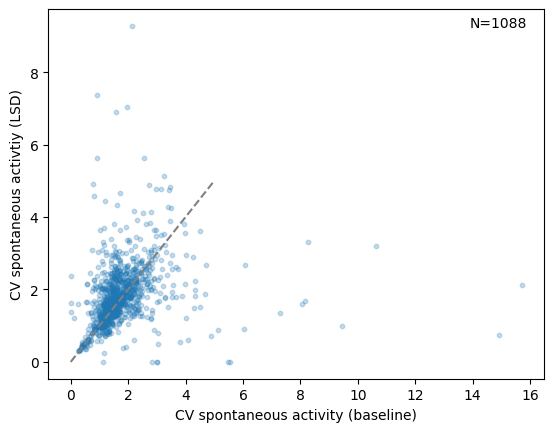

In [13]:
fig, ax = plt.subplots()
ax.scatter(df_spikes['cv_spontaneous_00'], df_spikes['cv_spontaneous_01'], s=10, alpha=0.25)
ax.plot([0, 5], [0, 5], color='gray', ls='--')
ax.text(0.85, 0.95, f'N={len(df_spikes)}', transform=ax.transAxes)
ax.set_xlabel('CV spontaneous activity (baseline)')
ax.set_ylabel('CV spontaneous activtiy (LSD)')
wilcoxon(df_spikes['cv_spontaneous_00'], df_spikes['cv_spontaneous_01'], nan_policy='omit')
print(np.nanmedian(df_spikes['cv_spontaneous_00']))
print(np.nanmedian(df_spikes['cv_spontaneous_01']))

WilcoxonResult(statistic=161246.0, pvalue=2.246604643817692e-27)

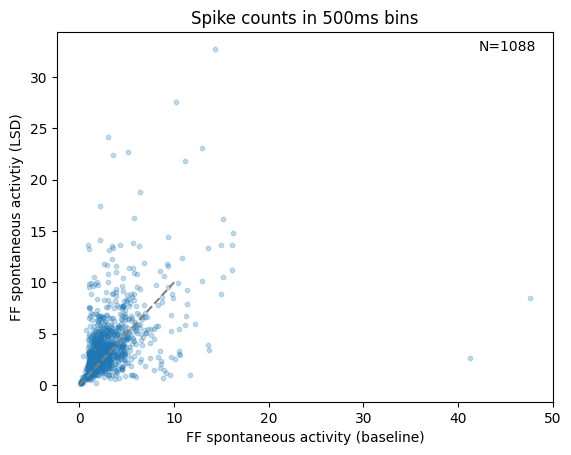

In [8]:
fig, ax = plt.subplots()
ax.set_title('Spike counts in 500ms bins')
ax.scatter(df_spikes['ff_spontaneous_00'], df_spikes['ff_spontaneous_01'], s=10, alpha=0.25)
ax.plot([0, 10], [0, 10], color='gray', ls='--')
ax.text(0.85, 0.95, f'N={len(df_spikes)}', transform=ax.transAxes)
ax.set_xlabel('FF spontaneous activity (baseline)')
ax.set_ylabel('FF spontaneous activtiy (LSD)')
wilcoxon(df_spikes['ff_spontaneous_00'], df_spikes['ff_spontaneous_01'], nan_policy='omit')

4.26578073089701
5.750830564784053


/home/crombie/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


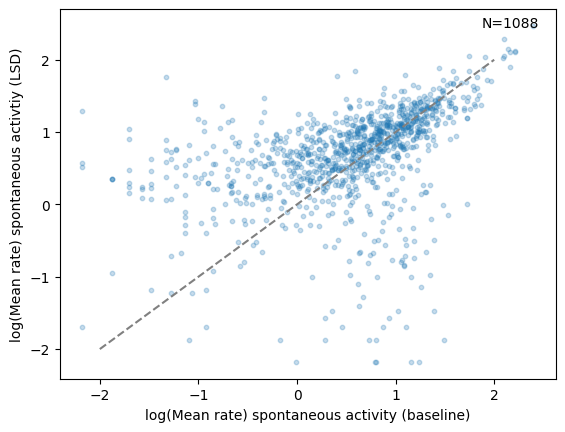

In [9]:
fig, ax = plt.subplots()
ax.scatter(np.log10(df_spikes['rate_spontaneous_00']), np.log10(df_spikes['rate_spontaneous_01']), s=10, alpha=0.25)
ax.plot([-2, 2], [-2, 2], color='gray', ls='--')
ax.text(0.85, 0.95, f'N={len(df_spikes)}', transform=ax.transAxes)
ax.set_xlabel('log(Mean rate) spontaneous activity (baseline)')
ax.set_ylabel('log(Mean rate) spontaneous activtiy (LSD)')
wilcoxon(df_spikes['rate_spontaneous_00'], df_spikes['rate_spontaneous_01'], nan_policy='omit')
print(np.nanmedian(df_spikes['rate_spontaneous_00']))
print(np.nanmedian(df_spikes['rate_spontaneous_01']))